# Cortical properties of structurally connected brain regions

In this notebook, the goal is to describe the cortical properties of brain regions that are structurally connected via white matter tracts. This is a preliminary version!
The notebook goes through the following steps: 

1. Load tract-to-region mapping: here, we are loading probabilistic tract-to-region maps publicly released by [Yeh 2022, Nature Methods](https://www.nature.com/articles/s41467-022-32595-4). This map is used to determine, for each white matter tract, which brain regions it is most likely connected to. 

2. Parcellate surface maps: selected cortical properties made publicly available as part of the [Neuromaps Pyhon package](https://netneurolab.github.io/neuromaps/).

3. Test for statistical significance: we'll test whether the cortical properties of structurally connected brain regions are significantly different compared to non-connected brain regions. 

In [34]:
# let's import the needed packages
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import images, datasets, images, nulls, resampling, stats, transforms
from surfplot import Plot
from neuromaps.parcellate import Parcellater
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
from neuromaps.parcellate import _gifti_to_array
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

## 1. Load tract-to-region mapping

Yeh's tract to brain region mapping system (see [link](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-32595-4/MediaObjects/41467_2022_32595_MOESM4_ESM.zip) is used to determine, for each white matter tract, which brain regions it is most likely connected to. 


Note that we'll be using the Glasser 360, also called HCP-MMP parcellation, as this is the most fine-grained parcellation (180 regions per hemisphere) provided in Yeh 2022 (other parcellations included Brodmann and Kleist, which have 39 and 49 regions, respectively).

These regions are then displayed for some of the main white matter tracts. 


A couple of notes about this tract-to-region matrix: 

* It contains population probabilities for each tract-to-region connection. This probability essentially indicates to what extent each given tract-to-region connection exists in the included sample of 1065 individuals. Tract-to-region connections that occur in most individuals will have a high probability, whereas tract-to-region connections that are rare will have a low probability. 
* The matrix does not contain commissural tracts (crossing fibers related limitations), brainstem, subcortical or cerebellar connections (due to insufficient slice coverage, insufficient spatial resolution to generate reliable tracking results). 
* Tract-to-region probabilities have been computed based on an adult sample (HCP, ages 22-37). 
* The matrix will have NAs for left hemisphere brain regions connecting to right hemisphere tracts, and vice versa (as no commissural tracts are listed here). 

In [9]:
# load Frank's Glasser tract-to-region matrix
tracts_regs = pd.read_excel("./Yeh_2022_source_data/fig5.xlsx", skiprows = 1, usecols = range(0, 53))

# rename columns (tract names)
columns = {}
for colidx, colname in enumerate(tracts_regs.columns):
    if colidx == 0:
        columns[colname] = f'parcel_name'
    if 1 <= colidx <= 26:
        columns[colname] = f'{colname}_left'
    elif colidx >= 27:
        columns[colname] = colname[:colname.index(".")] + "_right"
        
tracts_regs.rename(columns = columns, inplace = True)

# separate into L and R dataframes, rename parcel.name values
lh_tracts_regs = tracts_regs.filter(regex='^(parcel.name|.*_left$)')
rh_tracts_regs = tracts_regs.filter(regex='^(parcel.name|.*_right$)')  

lh_tracts_regs['LR'] = 'L'
lh_tracts_regs['parcel_name'] = lh_tracts_regs['parcel_name'].astype(str) + '_' + lh_tracts_regs['LR']
rh_tracts_regs['LR'] = 'R'
rh_tracts_regs['parcel_name'] = rh_tracts_regs['parcel_name'].astype(str) + '_' + rh_tracts_regs['LR']

# aggregate the two dataframes back again now that L and R regions are assigned
tracts_regs = pd.concat([lh_tracts_regs, rh_tracts_regs])
tracts_regs.shape

(360, 54)

In [8]:
tracts_regs

parcel_name  FAT_left   AF_left  PTAT_left  MdLF_left  SLF_III_left   
0         TGd_L       0.0  0.041315        0.0   0.259470           0.0  \
1       STSva_L       0.0  0.830047        0.0   0.641098           0.0   
2        TE1a_L       0.0  0.937089        0.0   0.644886           0.0   
3       STSda_L       0.0  0.590610        0.0   0.782197           0.0   
4        STGa_L       0.0  0.000939        0.0   0.719697           0.0   
..          ...       ...       ...        ...        ...           ...   
175       AVI_R       NaN       NaN        NaN        NaN           NaN   
176      a10p_R       NaN       NaN        NaN        NaN           NaN   
177      a47r_R       NaN       NaN        NaN        NaN           NaN   
178       11l_R       NaN       NaN        NaN        NaN           NaN   
179       47l_R       NaN       NaN        NaN        NaN           NaN   

     SLF_II_left  SLF_I_left  C_FP_left  C_R_left  ...  CST_right  CBT_right   
0            0.0         0.0        0.0       0.0  ...        NaN        NaN  \
1            0.0         0.0        0.0       0.0  ...        NaN        NaN   
2            0.0         0.0        0.0       0.0  ...        NaN        NaN   
3            0.0         0.0        0.0       0.0  ...        NaN        NaN   
4            0.0         0.0        0.0       0.0  ...        NaN        NaN   
..           ...         ...        ...       ...  ...        ...        ...   
175          NaN         NaN        NaN       NaN  ...        0.0        0.0   
176          NaN         NaN        NaN       NaN  ...        0.0        0.0   
177          NaN         NaN        NaN       NaN  ...        0.0        0.0   
178          NaN         NaN        NaN       NaN  ...        0.0        0.0   
179          NaN         NaN        NaN       NaN  ...        0.0        0.0   

     CStr_A_right  CStr_P_right  CStr_S_right  CTh_A_right  CTh_P_right   
0             NaN           NaN           NaN          NaN          NaN  \
1             NaN           NaN           NaN          NaN          NaN   
2             NaN           NaN           NaN          NaN          NaN   
3             NaN           NaN           NaN          NaN          NaN   
4             NaN           NaN           NaN          NaN          NaN   
..            ...           ...           ...          ...          ...   
175      0.661033           0.0      0.005634     0.083568          0.0   
176      1.000000           0.0      0.000000     0.985915          0.0   
177      1.000000           0.0      0.000000     0.992488          0.0   
178      0.973709           0.0      0.000000     0.485446          0.0   
179      0.974648           0.0      0.000000     0.734272          0.0   

     CTh_S_right  OR_right  F_right  
0            NaN       NaN      NaN  
1            NaN       NaN      NaN  
2            NaN       NaN      NaN  
3            NaN       NaN      NaN  
4            NaN       NaN      NaN  
..           ...       ...      ...  
175          0.0       0.0      0.0  
176          0.0       0.0      0.0  
177          0.0       0.0      0.0  
178          0.0       0.0      0.0  
179          0.0       0.0      0.0  

[360 rows x 54 columns]

### 1.1. Load Glasser 360 region ID file

Next, we need to know the region ID (number) corresponding to every brain region in the Glasser 360 (also called HCP-MMP) parcellation. We'll need these numbers in order to visualize the right parcels corresponding to each white matter tract. 

This list has been taken from: [here](https://neuroimaging-core-docs.readthedocs.io/en/latest/pages/atlases.html#how-to-download-and-install-additional-fsl-atlases), which lists several useful files provided by the original Glasser parcellation paper. Specifically, we'll use this csv: `HCP-MMP1_UniqueRegionList.csv`. Note that in this csv, `7Pl_L` and `7PL_R` need to be changed to `7PL_L` and `7PL_R` (so basically capitalizing the `L`) so that the merge with tract-to-region data works for these regions. 

Original Glasser paper: Glasser, M. F., Coalson, T. S., Robinson, E. C., Hacker, C. D., Harwell, J., Yacoub, E., et al. (2016). A multi-modal parcellation of human cerebral cortex. Nature, 1–11. http://doi.org/10.1038/nature18933

In [10]:
# load HCP-MMP regions list
glasser_ids = pd.read_csv('./inputs/HCP-MMP1_UniqueRegionList.csv')
glasser_ids.drop(columns = ['Cortex_ID', 'x-cog', 'y-cog', 'z-cog', 'volmm'], inplace = True)

# merge with the tract-to-regions data
tracts_regs_ids = pd.merge(tracts_regs, glasser_ids, left_on = 'parcel_name', right_on = 'regionName', how = 'left')
tracts_regs_ids.drop(columns = ['regionName', 'LR_y'], inplace = True)

In [11]:
# the tract-to-region dataframe now has additional columns containing Glasser region IDs
tracts_regs_ids

parcel_name  FAT_left   AF_left  PTAT_left  MdLF_left  SLF_III_left   
0         TGd_L       0.0  0.041315        0.0   0.259470           0.0  \
1       STSva_L       0.0  0.830047        0.0   0.641098           0.0   
2        TE1a_L       0.0  0.937089        0.0   0.644886           0.0   
3       STSda_L       0.0  0.590610        0.0   0.782197           0.0   
4        STGa_L       0.0  0.000939        0.0   0.719697           0.0   
..          ...       ...       ...        ...        ...           ...   
355       AVI_R       NaN       NaN        NaN        NaN           NaN   
356      a10p_R       NaN       NaN        NaN        NaN           NaN   
357      a47r_R       NaN       NaN        NaN        NaN           NaN   
358       11l_R       NaN       NaN        NaN        NaN           NaN   
359       47l_R       NaN       NaN        NaN        NaN           NaN   

     SLF_II_left  SLF_I_left  C_FP_left  C_R_left  ...  CTh_P_right   
0            0.0         0.0        0.0       0.0  ...          NaN  \
1            0.0         0.0        0.0       0.0  ...          NaN   
2            0.0         0.0        0.0       0.0  ...          NaN   
3            0.0         0.0        0.0       0.0  ...          NaN   
4            0.0         0.0        0.0       0.0  ...          NaN   
..           ...         ...        ...       ...  ...          ...   
355          NaN         NaN        NaN       NaN  ...          0.0   
356          NaN         NaN        NaN       NaN  ...          0.0   
357          NaN         NaN        NaN       NaN  ...          0.0   
358          NaN         NaN        NaN       NaN  ...          0.0   
359          NaN         NaN        NaN       NaN  ...          0.0   

     CTh_S_right  OR_right  F_right                   regionLongName   
0            NaN       NaN      NaN                 Area_TG_dorsal_L  \
1            NaN       NaN      NaN             Area_STSv_anterior_L   
2            NaN       NaN      NaN              Area_TE1_anterior_L   
3            NaN       NaN      NaN             Area_STSd_anterior_L   
4            NaN       NaN      NaN                      Area_STGa_L   
..           ...       ...      ...                              ...   
355          0.0       0.0      0.0  Anterior_Ventral_Insular_Area_R   
356          0.0       0.0      0.0              Area_anterior_10p_R   
357          0.0       0.0      0.0              Area_anterior_47r_R   
358          0.0       0.0      0.0                       Area_11l_R   
359          0.0       0.0      0.0          Area_47l_(47_lateral)_R   

     regionIdLabel  region  Lobe                         cortex  regionID  
0            131_L     TGd  Temp               Lateral_Temporal       131  
1            176_L   STSva  Temp           Auditory_Association       176  
2            132_L    TE1a  Temp               Lateral_Temporal       132  
3            128_L   STSda  Temp           Auditory_Association       128  
4            123_L    STGa  Temp           Auditory_Association       123  
..             ...     ...   ...                            ...       ...  
355          311_R     AVI   Ins  Insular_and_Frontal_Opercular       311  
356          289_R    a10p    Fr      Orbital_and_Polar_Frontal       289  
357          277_R    a47r    Fr               Inferior_Frontal       277  
358          291_R     11l    Fr      Orbital_and_Polar_Frontal       291  
359          276_R     47l    Fr               Inferior_Frontal       276  

[360 rows x 60 columns]

In [36]:
# save dataframe
tracts_regs_ids.sort_values(by = 'regionID', inplace = True)
region_col = tracts_regs_ids.pop('regionID')
tracts_regs_ids.insert(0, 'regionID', region_col)

# create outputs folder if doesn't yet exist
outputs_folder = './outputs'
if not os.path.exists(outputs_folder):
    os.makedirs(outputs_folder)
    print(f"Folder '{outputs_folder}' created.")
else:
    print(f"Folder '{outputs_folder}' already exists.")
    
tracts_regs_ids.to_csv(f'{outputs_folder}/tracts_regs_Glasser.csv', header = True, index = False)

## 2. Parcellate surface maps

### 2.1. Load and display Glasser 360 (HCP-MMP) parcellation

Let's start by loading the Glasser 360 parcellation, which corresponds to the HCP-MMP parcellation used in Yeh 2022. This parcellation contains 360 brain regions. We'll then display this parcellation using `surfplot`. 

A cool resource for Python-based neuroimaging tutorials (useful also for working with parcellations):
https://dartbrains.org/content/Parcellations.html

In [13]:
# load Glasser brain region ID labels
root = './inputs/'
lh_glasser_name = 'glasser_360_L.label.gii' 
lh_glasser = nib.load(os.path.join(root, lh_glasser_name))
rh_glasser_name = 'glasser_360_R.label.gii'
rh_glasser = nib.load(os.path.join(root, rh_glasser_name))

# print the labels
print(f'left hemisphere: \n {np.unique(lh_glasser.darrays[0].data)}; \n right hemisphere: \n {np.unique(rh_glasser.darrays[0].data)}')

left hemisphere: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]; 
 right hemisphere: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  5

Note: the numbers are identical in each label file, but we need them to be consecutive (1-180 = left hemisphere, 201-360 = right hemisphere) for neuromaps and integration with tract-to-region mapping below.

In [14]:
# relabel them so that they are consecutive:
parcellation = images.relabel_gifti((lh_glasser, rh_glasser), background=['Medial_wall'])

# # check that parcels are now numbered consecutively
print(f'new left hemisphere: \n {np.unique(parcellation[0].darrays[0].data)}; \n new right hemisphere: \n {np.unique(parcellation[1].darrays[0].data)}')
# this looks better! But the right hemisphere starts at 181, and conventionally (as well as for tract-to-region mapping below) we need it to start at 201.

# let's add 20 to all elements except for elements with value 0
rh_glasser_orig = parcellation[1].darrays[0].data
parcellation[1].darrays[0].data = np.where(parcellation[1].darrays[0].data != 0, rh_glasser_orig + 20, rh_glasser_orig)

print(f'final right hemisphere: \n {np.unique(parcellation[1].darrays[0].data)}')
# all good now! 

# let's assign these labels so that we can call them later for plotting
lh_glasser = parcellation[0]
rh_glasser = parcellation[1]

# let's save this to use in other notebooks
nib.save(lh_glasser, os.path.join(root, 'glasser_360_L_correct.label.gii'))
nib.save(rh_glasser, os.path.join(root, 'glasser_360_R_correct.label.gii'))

new left hemisphere: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180]; 
 new right hemisphere: 
 [  0 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232

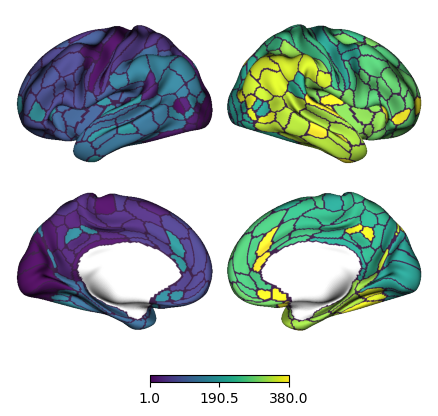

In [15]:
# display Glasser 360 parcellation
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh, brightness = 0.9) # brightness of the brain, from 0 (black) to 1 (white)

# build plot
p.add_layer({'left': lh_glasser, 'right': rh_glasser}, cbar = True)
p.add_layer({'left': lh_glasser, 'right': rh_glasser}, cmap = 'turbo', 
            as_outline = True, cbar = False)

fig = p.build()
fig.show()

### 2.2. Visualize structurally connected brain regions - an example

Let's visualize the brain regions that each white matter tract connects to. 
For instance, let's see what regions are connected to the left Arcuate Fasciculus (AF).

In [12]:
# show brain regions connected to the AF in most people (>95% probability of connection)
left_AF = tracts_regs_ids.loc[tracts_regs_ids['AF_left'] > 0.95, ['parcel_name', 'regionLongName', 'cortex', 'regionID']]
print(f'Number of brain regions structurally connected to the left AF: {len(left_AF)}')
left_AF

Number of brain regions structurally connected to the left AF: 20


parcel_name                   regionLongName   
10         A4_L             Auditory_4_Complex_L  \
11      PBelt_L               ParaBelt_Complex_L   
15       TE1p_L             Area_TE1_posterior_L   
16       TE1m_L                Area_TE1_Middle_L   
17      STSvp_L            Area_STSv_posterior_L   
19       TE2a_L              Area_TE2_anterior_L   
20         A5_L             Auditory_5_Complex_L   
22        PHT_L                       Area_PHT_L   
31         PH_L                        Area_PH_L   
86       FOP4_L       Frontal_Opercular_Area_4_L   
88         6r_L                 Rostral_Area_6_L   
89         44_L                        Area_44_L   
92       IFJa_L                      Area_IFJa_L   
95         6v_L                 Ventral_Area_6_L   
107       STV_L  Superior_Temporal_Visual_Area_L   
108        RI_L            RetroInsular_Cortex_L   
111      PFcm_L                      Area_PFcm_L   
112       PSL_L      PeriSylvian_Language_Area_L   
120        43_L                        Area_43_L   
124         4_L           Primary_Motor_Cortex_L   

                                       cortex  regionID  
10                       Auditory_Association       175  
11                             Early_Auditory       124  
15                           Lateral_Temporal       133  
16                           Lateral_Temporal       177  
17                       Auditory_Association       130  
19                           Lateral_Temporal       134  
20                       Auditory_Association       125  
22                           Lateral_Temporal       137  
31   MT+_Complex_and_Neighboring_Visual_Areas       138  
86              Insular_and_Frontal_Opercular       108  
88                                   Premotor        78  
89                           Inferior_Frontal        74  
92                           Inferior_Frontal        79  
95                                   Premotor        56  
107        Temporo-Parieto-Occipital_Junction        28  
108                            Early_Auditory       104  
111                            Early_Auditory       105  
112        Temporo-Parieto_Occipital_Junction        25  
120                       Posterior_Opercular        99  
124                   Somatosensory_and_Motor         8

Ok, looks like the left AF is connected to 20 brain regions, mostly in lateral temporal and frontal regions - that makes sense.

To visualize these regions on a cortical surface, we need to assign a value of 0 to all other region indices. 

[ 35  52  12 ... 133 133 133] [175 124 133 177 130 134 125 137 138 108  78  74  79  56  28 104 105  25
  99   8]


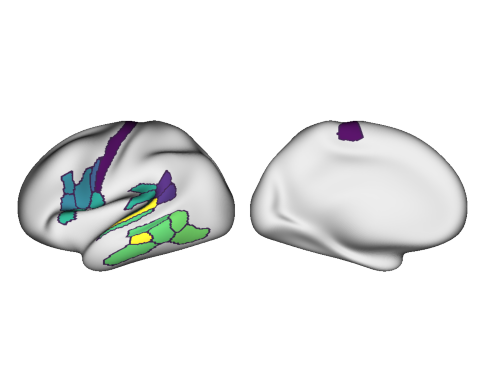

In [16]:
# get Glasser labels
lhlabels = lh_glasser.darrays[0].data.astype(int)

# get brain regions for AF
region_numbers = np.array(left_AF['regionID'].astype('int'))

np.unique(lhlabels)
print(lhlabels, region_numbers)

# zero-out all regions except those connected to the AF
af_regions = np.where(np.isin(lhlabels, region_numbers), lhlabels, 0)
len(np.unique(af_regions))

# plot brain regions connected to the AF
surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']

p = Plot(lh, views=['lateral', 'medial'], brightness = 0.7, zoom = 1.2)
p.add_layer(af_regions, cmap = 'viridis', cbar = False) # colors
p.add_layer(af_regions, cmap = 'turbo', as_outline = True, cbar = False) # outline

fig = p.build()
fig.show()


Let's also display the corresponding tract (for now this is a jpg screenshot of the tract loaded in DSI Studio):

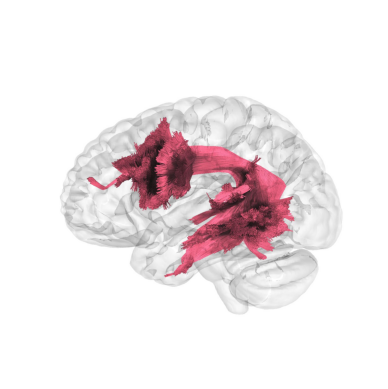

In [17]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

# load tract image
tract_filepath='./tracts/figures/left_hem/0197_pnc_template.Arcuate_Fasciculus_L.jpg'
tract_img = mpimg.imread(tract_filepath)

# show plot
plt.axis('off')
plt.imshow(tract_img)


### 2.3. Load selected surface maps and parcellate them into Glasser 360

The first step is to load some neuromaps cortical properties we're interested in. 

Let's load: 

* S-A axis ranks
* cortical thickness
* the first functional connectivity gradient
* intracortical myelination

In [20]:
# load maps of interest
sa_axis = fetch_annotation(source = 'sydnor2021', desc = 'SAaxis',
                                       space = 'fsLR', den = '32k')

thickness = fetch_annotation(source = 'hcps1200', desc = 'thickness',
                                       space = 'fsLR', den = '32k')

fc_pc1 = fetch_annotation(source = 'margulies2016', desc = 'fcgradient01',
                                       space = 'fsLR', den = '32k')

myelin = fetch_annotation(source = 'hcps1200', desc = 'myelinmap',
                                       space = 'fsLR', den = '32k')

Then, we'll need to parcellate these maps to get regionwise values of the above cortical properties within the Glasser parcellation, as that's the parcellation we have for the tract-to-region mapping.

In [22]:
# load Glasser 360 parcellation (GIfTI label files)
root = './inputs/'
lh_glasser_name = 'glasser_360_L_correct.label.gii' 
lh_glasser = nib.load(os.path.join(root, lh_glasser_name))
rh_glasser_name = 'glasser_360_R_correct.label.gii'
rh_glasser = nib.load(os.path.join(root, rh_glasser_name))

In [24]:
# generate neuromaps fsLR based Glasser 360 parcellation (needs relabeling otherwise we don't end up with the right total number of parcels)
glasser = images.relabel_gifti((lh_glasser, rh_glasser), background=['Medial_wall'])

# check that parcels are numbered consecutively, with a jump from 180 to 201 for the right hemisphere
# print(f'new left hemisphere: \n {np.unique(parcellation[0].darrays[0].data)}; \n new right hemisphere: \n {np.unique(parcellation[1].darrays[0].data)}')

glasser_parc = Parcellater(glasser, 'fsLR').fit()
print(glasser_parc) # not sure how to check that the parcellation looks correct?

In [25]:
# apply Glasser parcellation to surface maps of interest
sa_axis_glasser = glasser_parc.fit_transform(sa_axis, 'fsLR')
thickness_glasser = glasser_parc.fit_transform(sa_axis, 'fsLR')
fc_pc1_glasser = glasser_parc.fit_transform(fc_pc1, 'fsLR')
myelin_glasser = glasser_parc.fit_transform(myelin, 'fsLR')

# show dimensions of parcellated maps
print(sa_axis_glasser.shape, thickness_glasser.shape, fc_pc1_glasser.shape, myelin_glasser.shape)

(360,) (360,) (360,) (360,)


#### Visualize parcellated surface maps

Now that we've parcellated a few cortical properties into Glasser regions, let's visualize them! For that, we'll use a custom made visualization function provided by Golia Shafiei (thanks!!), which relies on Mayavi and Netneurotools. You might note that the surface used here is different than usual (we're plotting on the Conte69 surface instead of fsLR), this does not matter for the purposes of visualization. 

Note: running the plotting chunk will open python instances on your local computer in a bunch of different windows. The images have already been generated and saved under 

In [26]:
# from netneurotools import plotting # need to fix scipy installation

# define plotting function (on conte 69 surface here, this doesn't matter) - from Golia Shafiei
def plot_conte69(data, lhlabel, rhlabel, surf='midthickness',
                 vmin=None, vmax=None, colormap='viridis', customcmap=None,
                 colorbar=True, num_labels=4, orientation='horizontal',
                 colorbartitle=None, backgroundcolor=(1, 1, 1),
                 foregroundcolor=(0, 0, 0), **kwargs):

    """
    Plots surface `data` on Conte69 Atlas

    (This is a modified version of plotting.plot_conte69 from netneurotools.
     This version will be merged with the one on netneurotools in future.)

    Parameters
    ----------
    data : (N,) array_like
        Surface data for N parcels
    lhlabel : str
        Path to .gii file (generic GIFTI file) containing labels to N/2 parcels
        on the left hemisphere
    rhlabel : str
        Path to .gii file (generic GIFTI file) containing labels to N/2 parcels
        on the right hemisphere
    surf : {'midthickness', 'inflated', 'vinflated'}, optional
        Type of brain surface. Default: 'midthickness'
    vmin : float, optional
        Minimum value to scale the colormap. If None, the min of the data will
        be used. Default: None
    vmax : float, optional
        Maximum value to scale the colormap. If None, the max of the data will
        be used. Default: None
    colormap : str, optional
        Any colormap from matplotlib. Default: 'viridis'
    colorbar : bool, optional
        Wheter to display a colorbar. Default: True
    num_labels : int, optional
        The number of labels to display on the colorbar.
        Available only if colorbar=True. Default: 4
    orientation : str, optional
        Defines the orientation of colorbar. Can be 'horizontal' or 'vertical'.
        Available only if colorbar=True. Default: 'horizontal'
    colorbartitle : str, optional
        The title of colorbar. Available only if colorbar=True. Default: None
    backgroundcolor : tuple of float values with RGB code in [0, 1], optional
        Defines the background color. Default: (1, 1, 1)
    foregroundcolor : tuple of float values with RGB code in [0, 1], optional
        Defines the foreground color (e.g., colorbartitle color).
        Default: (0, 0, 0)
    kwargs : key-value mapping
        Keyword arguments for `mayavi.mlab.triangular_mesh()`

    Returns
    -------
    scene : mayavi.Scene
        Scene object containing plot
    """

    from netneurotools.datasets import fetch_conte69
    try:
        from mayavi import mlab
    except ImportError:
        raise ImportError('Cannot use plot_conte69() if mayavi is not '
                          'installed. Please install mayavi and try again.')

    opts = dict()
    opts.update(**kwargs)

    try:
        surface = fetch_conte69()[surf]
    except KeyError:
        raise ValueError('Provided surf "{}" is not valid. Must be one of '
                         '[\'midthickness\', \'inflated\', \'vinflated\']'
                         .format(surf))
    lhsurface, rhsurface = [nib.load(s) for s in surface]

    lhlabels = nib.load(lhlabel).darrays[0].data
    rhlabels = nib.load(rhlabel).darrays[0].data
    lhvert, lhface = [d.data for d in lhsurface.darrays]
    rhvert, rhface = [d.data for d in rhsurface.darrays]

    # add NaNs for subcortex
    data = np.append(np.nan, data)

    # get lh and rh data
    lhdata = np.squeeze(data[lhlabels.astype(int)])
    rhdata = np.squeeze(data[rhlabels.astype(int)])

    # plot
    lhplot = mlab.figure()
    rhplot = mlab.figure()
    lhmesh = mlab.triangular_mesh(lhvert[:, 0], lhvert[:, 1], lhvert[:, 2],
                                  lhface, figure=lhplot, colormap=colormap,
                                  mask=np.isnan(lhdata), scalars=lhdata,
                                  vmin=vmin, vmax=vmax, **opts)
    lhmesh.module_manager.scalar_lut_manager.lut.nan_color = [0.863, 0.863,
                                                              0.863, 1]
    lhmesh.update_pipeline()
    if type(customcmap) != str:
        lut = lhmesh.module_manager.scalar_lut_manager.lut.table.to_array()
        lut[:, :3] = customcmap.colors * 255
        lhmesh.module_manager.scalar_lut_manager.lut.table = lut
        mlab.draw()
    if colorbar is True:
        mlab.colorbar(title=colorbartitle, nb_labels=num_labels,
                      orientation=orientation)
    rhmesh = mlab.triangular_mesh(rhvert[:, 0], rhvert[:, 1], rhvert[:, 2],
                                  rhface, figure=rhplot, colormap=colormap,
                                  mask=np.isnan(rhdata), scalars=rhdata,
                                  vmin=vmin, vmax=vmax, **opts)
    rhmesh.module_manager.scalar_lut_manager.lut.nan_color = [0.863, 0.863,
                                                              0.863, 1]
    rhmesh.update_pipeline()
    if type(customcmap) != str:
        lut = rhmesh.module_manager.scalar_lut_manager.lut.table.to_array()
        lut[:, :3] = customcmap.colors * 255
        rhmesh.module_manager.scalar_lut_manager.lut.table = lut
        mlab.draw()
    if colorbar is True:
        mlab.colorbar(title=colorbartitle, nb_labels=num_labels,
                      orientation=orientation)
    mlab.view(azimuth=180, elevation=90, distance=450, figure=lhplot)
    mlab.view(azimuth=180, elevation=-90, distance=450, figure=rhplot)

    mlab.figure(bgcolor=backgroundcolor, fgcolor=foregroundcolor,
                figure=lhplot)
    mlab.figure(bgcolor=backgroundcolor, fgcolor=foregroundcolor,
                figure=rhplot)

    return lhplot, rhplot

In [ ]:
import mayavi
import nibabel as nib

# get glasser parcellations (originals provided by Golia as need indices not to exceed 361 here)
root = './inputs/'
lh_glasser_name = os.path.join(root, 'glasser_360_L.label.gii') 
rh_glasser_name = os.path.join(root, 'glasser_360_R.label.gii')


# plot all selected maps
maps_list = [sa_axis_glasser, thickness_glasser, fc_pc1_glasser, myelin_glasser]
map_names = ['sa_axis', 'thickness', 'fc_pc1', 'myelin']
colors = ['magma', 'viridis', 'PiYG', 'Spectral']

for index, mp in enumerate(maps_list):
    # set color
    color = colors[index]
    map_name = map_names[index]
    
    # plot da map
    brains = plot_conte69(mp, lh_glasser_name, rh_glasser_name,
                          vmin=np.percentile(mp, 0), # min map value (do 2.5% if want 95% confidence interval, in case of map outliers)
                          vmax=np.percentile(mp, 100), # max map value (or 97.5%)
                          colormap = color, customcmap = color,
                          colorbartitle=('test'),
                          surf='inflated')

    # save color bar
    # create outputs folder if doesn't yet exist
    outputs_folder = './outputs/parcellated_maps'
    if not os.path.exists(outputs_folder):
        os.makedirs(outputs_folder)
        print(f"Folder '{outputs_folder}' created.")
    else:
        print(f"Folder '{outputs_folder}' already exists.")
    
    mayavi.mlab.savefig(f'{outputs_folder}/lh_{map_name}_vals.png',
                        figure=brains[0])

    # save lateral views
    mayavi.mlab.figure(brains[0]).scene.parallel_projection = True
    mayavi.mlab.figure(brains[1]).scene.parallel_projection = True
    mayavi.mlab.figure(brains[0]).scene.background = (1, 1, 1)
    mayavi.mlab.figure(brains[1]).scene.background = (1, 1, 1)

    mayavi.mlab.savefig(f'{outputs_folder}/lh_{map_name}_lat.png', figure=brains[0])
    mayavi.mlab.savefig(f'{outputs_folder}/rh_{map_name}_lat.png', figure=brains[1])

    # save medial views
    mayavi.mlab.view(azimuth=0, elevation=90, distance=450, figure=brains[0])
    mayavi.mlab.view(azimuth=0, elevation=-90, distance=450, figure=brains[1])

    mayavi.mlab.savefig(f'{outputs_folder}/lh_{map_name}_med.png', figure=brains[0])
    mayavi.mlab.savefig(f'{outputs_folder}/rh_{map_name}_med.png', figure=brains[1])
    
    mayavi.mlab.close(all = True)

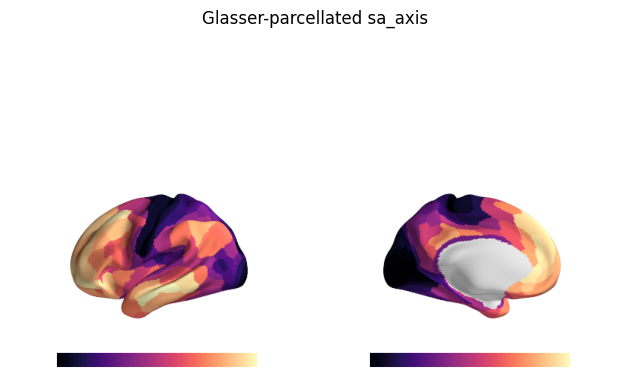

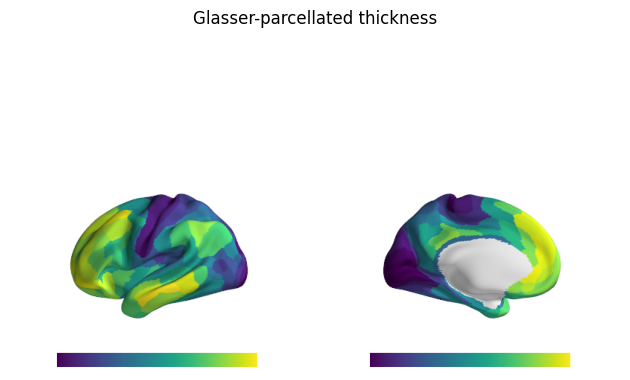

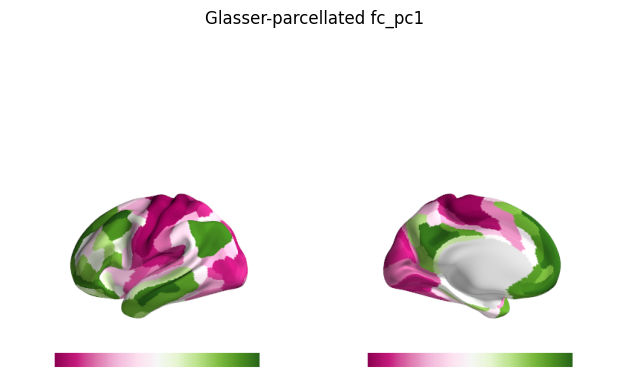

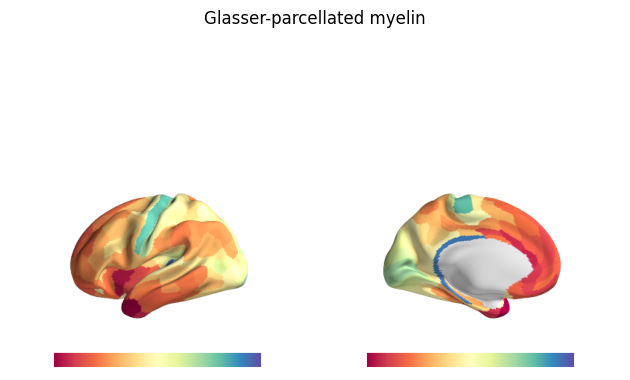

In [35]:
# all selected maps
map_names = ['sa_axis', 'thickness', 'fc_pc1', 'myelin']
path = './outputs/parcellated_maps/'

# loop over all selected brain maps
for index, map_name in enumerate(map_names):

    # Create a figure and axes for the grid of subplots
    fig, axes = plt.subplots(1, 2)

    # Load saved images and display them in the subplot
    lat_image = Image.open(f'{path}/lh_{map_name}_lat.png')
    med_image = Image.open(f'{path}/lh_{map_name}_med.png')
    axes[0].imshow(lat_image)
    axes[1].imshow(med_image)
    axes[0].axis('off')
    axes[1].axis('off')
    
    # Set the title for the entire plot
    fig.suptitle(f'Glasser-parcellated {map_name}')

    # Adjust the layout and spacing of the subplots
    plt.tight_layout()

    # Save the figure containing the grid of subplots
#     plt.savefig(f'/Users/joelleba/PennLINC/tractmaps/outputs/plots/parcellated_{map_name}.png')

    # Show the plot grid (optional)
    plt.show()

## 3. Test for statistical significance

How similar are structurally connected brain regions?

You might wonder if brain regions that are structurally connected to a given white matter tract might have similar cortical properties. For instance, maybe brain regions connected to the arcuate fasciculus are thicker and have more myelin (totally made up, probably not true!). 

### 3.1. Case study: zooming into the left arcuate fasciculus

Let's first work with an example. We'll define structurally connected vs non-connected regions for the left arcuate fasciculus, and compare intracortical myelin in connected vs non-connected regions using a two sample, two-tailed t-test. Next, we'll generate a null distribution of this by shuffling parcellated myelin values, yielding a new randomly assigned parcellated myelin map (we keep the same tract-to-region mapping). Then we do the t-test again. We do this 100 times to get a null distribution of differences between the two maps. We can then plot this against the empirically obtained map difference. 
If our hypothesis is correct, then we should find that structurally connected regions have significantly different myelin values compared to non-connected regions. 

#### Empirical test comparing map values in connected vs non-connected brain regions

First, let's compute the t-test examining the difference between parcellated myelin values of regions that are structurally connected vs non-connected to the left arcuate fasciculus. 

Note: I wonder if here we should only test against non-connected regions of the **same** hemisphere?

In [37]:
# load tract-to-region csv
tracts_regs_ids = pd.read_csv('./outputs/tracts_regs_Glasser.csv')

# select brain regions connected to the AF in most people (>95% probability of connection)
left_AF = tracts_regs_ids.loc[tracts_regs_ids['AF_left'] > 0.95, ['parcel_name', 'regionLongName', 'cortex', 'regionID']]
# print(f'Number of brain regions structurally connected to the left AF: {len(left_AF)}')

# select brain region indices
left_AF_idx = tracts_regs_ids.index[tracts_regs_ids['AF_left'] > 0.95].tolist()
# left_AF_idx

# create array with map values of connected brain regions
connected = [myelin_glasser[i] for i in left_AF_idx]
print(f'Number of brain regions structurally connected to the left AF: {len(connected)}') 

# create array with map values of non-connected regions
non_connected = [myelin_glasser[i] for i in range(len(myelin_glasser)) if i not in left_AF_idx]
print(f'Number of brain regions NOT structurally connected to the left AF: {len(non_connected)}') 

# two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
from scipy.stats import ttest_ind
from statistics import mean

# In this case we have two sample arrays: structurally connected and non-connected regions
# Perform the t-test
empirical_t_statistic, empirical_p_value = ttest_ind(connected, non_connected)

# compute the difference in the means (will be used for plotting)
empirical_mean_diff = mean(connected) - mean(non_connected)

# Print the results
print("Empirical T-Statistic:", round(empirical_t_statistic, 3))
print("Empirical P-Value:", round(empirical_p_value, 3))
print("Empirical difference in means:", round(empirical_mean_diff, 3))

Number of brain regions structurally connected to the left AF: 20
Number of brain regions NOT structurally connected to the left AF: 340
Empirical T-Statistic: 0.351
Empirical P-Value: 0.726
Empirical difference in means: 0.01


#### Generate nulls

The next step is to generate a null distribution for this test by randomly shuffling the parcellated myelin map.

In [38]:
from scipy.stats import ttest_ind
from statistics import mean

# permute the parcellated map - this gives a new randomly assigned map values (for instance, myelin) for each brain region
rotated_maps = nulls.alexander_bloch(myelin_glasser, atlas = 'fsLR', density = '32k',
                                n_perm = 100, seed = 1234, parcellation = glasser)
# print(rotated.shape)
# rotated[:,2]

# null result lists
null_t_stats = []
null_p_vals = []
null_mean_diffs = []

# select brain region indices
left_AF_idx = tracts_regs_ids.index[tracts_regs_ids['AF_left'] > 0.95].tolist()

# generate null distribution (using neuromaps spatial nulls)
for map_index, rotated_map in enumerate(rotated_maps):
    
    if map_index < 100: # loop until the 99th iteration, which corresponds to the 100th and last column
       
        # assign the brain regions as connected vs non-connected for each of the 100 permuted maps (columns), except now the map values have been shuffled
        connected = [rotated_maps[i, map_index] for i in left_AF_idx]
        non_connected = [rotated_maps[i, map_index] for i in range(len(rotated_maps)) if i not in left_AF_idx] # NOTE: could limit this to same hemisphere regions
#         print(f'Number of brain regions structurally connected to the left AF: {len(connected)}') 
#         print(f'Number of brain regions NOT structurally connected to the left AF: {len(non_connected)}') 

        # two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
        t_statistic, p_value = ttest_ind(connected, non_connected)

        # compute the difference in the means (will be used for plotting)
        mean_diff = mean(connected) - mean(non_connected)

        # print the results
#         print(f'Map number: {map_index}')
#         print("T-Statistic:", round(t_statistic, 3))
#         print("P-Value:", round(p_value, 3))
#         print("Difference in means:", round(mean_diff, 3))

        # save the results
        null_t_stats.append(round(t_statistic, 3))
        null_p_vals.append(round(p_value, 3))
        null_mean_diffs.append(round(mean_diff, 3))
        


#### Visualize the results

Finally, let's plot the null distribution and the empirical result. See figure 2c in this paper: https://elifesciences.org/articles/62116

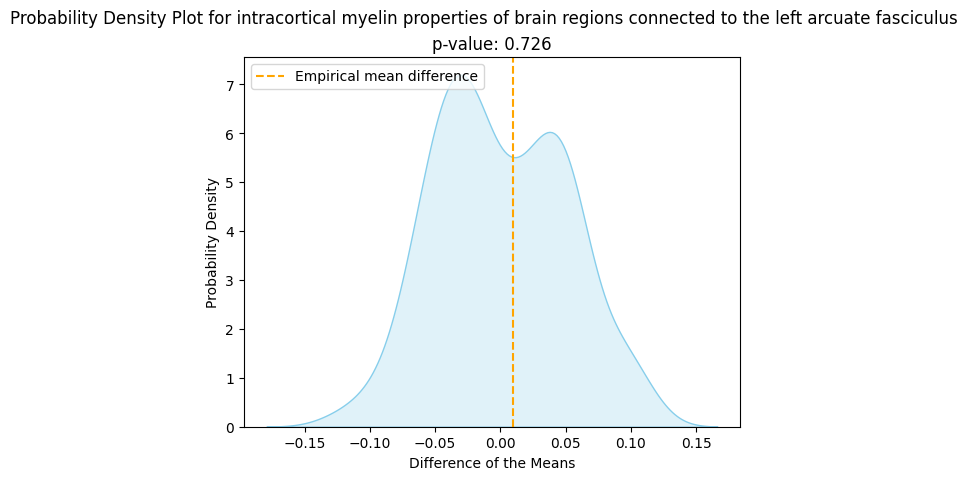

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a probability density plot using KDE
sns.kdeplot(null_mean_diffs, shade = True, color = 'skyblue')

# Add a vertical line at the empirical mean difference (i.e. for the non-rotated original map)
plt.axvline(x = empirical_mean_diff, color = 'orange', linestyle='--', label = 'Empirical mean difference')

# Add labels and title
plt.xlabel('Difference of the Means')
plt.ylabel('Probability Density')
plt.suptitle('Probability Density Plot for intracortical myelin properties of brain regions connected to the left arcuate fasciculus')
plt.title(f'p-value: {round(empirical_p_value, 3)}')
plt.legend()

# Show the plot
plt.show()

Note that the map values (myelin, in this case) have been standardized. 

### 3.2. Expand to all tracts and all maps

Now, let's do the same test but for all tracts and plot this - once collapsed across all tracts, and once as a grid displaying results per tract. 
We'll do this for every map we want to look at: S-A axis, cortical thickness, myelin and the first FC gradient.

In [42]:
from scipy.stats import ttest_ind
from statistics import mean
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# load tract-to-region csv
tracts_regs_ids = pd.read_csv('./outputs/tracts_regs_Glasser.csv')

# define white matter tracts to loop over 
tracts = tracts_regs_ids.filter(regex='left|right').columns

# all selected maps
maps_list = [sa_axis_glasser, thickness_glasser, fc_pc1_glasser, myelin_glasser]
map_names = ['sa_axis', 'thickness', 'fc_pc1', 'myelin']
density_colors = ['orchid', 'gold', 'mediumseagreen', 'skyblue']

# dictionary to store results for each map
all_emps_mean_diffs = {} # empirical results
all_nulls_mean_diffs = {} # null results
all_image_paths = {} # figures for all plots corresponding to each map

# loop over all selected brain maps
for index, mp in enumerate(maps_list):
    
    # set color and map name
    density_color = density_colors[index]
    map_name = map_names[index]

    # create nulls by shuffling the parcellated map - this gives a new randomly assigned map values (for instance, myelin) for each brain region
    rotated_maps = nulls.alexander_bloch(mp, atlas = 'fsLR', density = '32k',
                                    n_perm = 100, seed = 1234, parcellation = glasser)
    # print(rotated.shape)
    # rotated[:,1]

    # generate results lists
    plots = [] # to store plots
    image_paths = [] # to store plot paths
    tracts_emps_mean_diffs = [] # to store all empirical results collapsed across tracts
    tracts_nulls_mean_diffs = [] # to store all null results collapsed across tracts

    # loop over tracts
    for index, tract in enumerate(tracts):

        # empirical result lists
        emp_t_stats = []
        emp_p_vals = []
        emp_mean_diffs = []

        # null result lists
        null_t_stats = []
        null_p_vals = []
        null_mean_diffs = []

        ### EMPIRICAL RESULTS ###
        # select brain regions connected to the tract in most people (>95% probability of connection)
    #     tract_df = tracts_regs_ids.loc[tracts_regs_ids[f'{tract}'] > 0.95, ['parcel_name', 'regionLongName', 'cortex', 'regionID']]
    #     print(f'Number of brain regions structurally connected to the left AF: {len(left_AF)}')

        # select brain region indices
        tract_regs_idx = tracts_regs_ids.index[tracts_regs_ids[f'{tract}'] > 0.95].tolist()

        # create array with map values of connected brain regions
        connected = [mp[i] for i in tract_regs_idx]
    #     print(f'Number of brain regions structurally connected to the {tract}: {len(connected)}') 

        # create array with map values of non-connected regions
        non_connected = [mp[i] for i in range(len(mp)) if i not in tract_regs_idx]
    #     print(f'Number of brain regions NOT structurally connected to the {tract}: {len(non_connected)}') 

        # two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
        empirical_t_statistic, empirical_p_value = ttest_ind(connected, non_connected)

        # compute the difference in the means (will be used for plotting)
        empirical_mean_diff = mean(connected) - mean(non_connected)

        # Print the results
    #     print(f"{tract} - Empirical T-Statistic:", round(empirical_t_statistic, 3))
    #     print(f"{tract} - Empirical P-Value:", round(empirical_p_value, 3))
    #     print(f"{tract} - Empirical difference in means:", round(empirical_mean_diff, 3))

        # save the results
        emp_t_stats.append(round(empirical_t_statistic, 3))
        emp_p_vals.append(round(empirical_p_value, 3))
        emp_mean_diffs.append(round(empirical_mean_diff, 3))
        tracts_emps_mean_diffs.append(round(empirical_mean_diff, 3))
        

        ### NULL RESULTS ###
        # generate null distribution (using neuromaps spatial nulls)
        for map_index, rotated_map in enumerate(rotated_maps):

            if map_index < 100: # loop until the 99th iteration, which corresponds to the 100th and last column

                # assign the brain regions as connected vs non-connected for each of the 100 permuted maps (columns), except now the map values have been shuffled
                connected = [rotated_maps[i, map_index] for i in tract_regs_idx]
                non_connected = [rotated_maps[i, map_index] for i in range(len(rotated_maps)) if i not in tract_regs_idx] # NOTE: could limit this to same hemisphere regions
    #             print(f'Number of brain regions structurally connected to the left AF: {len(connected)}') 
    #             print(f'Number of brain regions NOT structurally connected to the left AF: {len(non_connected)}') 

                # two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
                t_statistic, p_value = ttest_ind(connected, non_connected)

                # compute the difference in the means (will be used for plotting)
                mean_diff = mean(connected) - mean(non_connected)

                # print the results
    #             print(f'Map number: {map_index}')
    #             print("T-Statistic:", round(t_statistic, 3))
    #             print("P-Value:", round(p_value, 3))
    #             print("Difference in means:", round(mean_diff, 3))

                # save the results
                null_t_stats.append(round(t_statistic, 3))
                null_p_vals.append(round(p_value, 3))
                null_mean_diffs.append(round(mean_diff, 3))
                tracts_nulls_mean_diffs.append(round(mean_diff, 3))


        ### PLOTTING ###

        # Create a new figure for each plot
        fig = plt.figure()

        # Create a probability density plot using KDE
        sns.kdeplot(null_mean_diffs, shade = True, color = density_color)

        # Add a vertical line at the empirical mean difference (i.e. for the non-rotated original map)
        plt.axvline(x = empirical_mean_diff, color = 'orange', linestyle='--', label = 'Empirical mean difference')

        # Add labels and title
        plt.xlabel('Difference of the Means')
        plt.ylabel('Probability Density')
        plt.suptitle(f'{map_name} properties of connected vs non-connected regions in the {tract}')
        plt.title(f'p-value: {round(empirical_p_value, 3)}')
        plt.legend()

        # Show the plot
    #     plt.show()

       # Append the current plot to the list
        plots.append(fig)

        # Clear the current figure for the next iteration
        plt.close(fig)

        
        # create outputs folder if doesn't yet exist
        outputs_folder = './outputs/statistical_testing'
        if not os.path.exists(outputs_folder):
            os.makedirs(outputs_folder)
            print(f"Folder '{outputs_folder}' created.")
        else:
            print(f"Folder '{outputs_folder}' already exists.")
        
        # Save the figure as an image
        image_path = f'./outputs/statistical_testing/plot_{map_name}_{tract}.png'
        fig.savefig(image_path)
        plt.close(fig)

        # Append the path of the saved image to the list
        image_paths.append(image_path)
        
    # save results for each map (collapsed across all tracts)
    all_emps_mean_diffs[f'{map_name}'] = tracts_emps_mean_diffs
    all_nulls_mean_diffs[f'{map_name}'] = tracts_nulls_mean_diffs
    all_image_paths[f'{map_name}'] = image_paths
    

    

#### Plot a grid of results for each tract separately

These plots show the null distribution for the difference in the mean myelin map value of structurally connected vs non-connected regions, separately for each tract. Here, the goal is to see whether the pattern is similar across all tracts, or if perhaps some tracts have unique features.

**Note: not 100% how to interpret a positive difference in the means... Maps were standardized but I suppose the sign of the values is still the same?**

The difference in means is computed as map values in connected regions - map values of non-connectede regions. So a positive difference I think means that the map values were higher in connected vs non-connected regions.

Based on the plots below, it looks like some tracts (e.g., the `MdLF_left` which corresponds to the Middle Longitudinal Fasciculus, `C_FPH_left` corresponding to Frontal Parahippocampal Cingulum, and more) have a positive the  difference of the means in myelin, for instance. This indicates that empirically, the myelin values of regions structurally connected to these tracts were higher, compared to non-connected brain regions. 

Conversely, in some tracts like the C_R_left, which corresponds to the Parolfactory Cingulum, myelin values were significantly lower in connected compared to non-connected brain regions. The main trend seems to be higher myelin in structurally connected regions though.

Pretty cool!

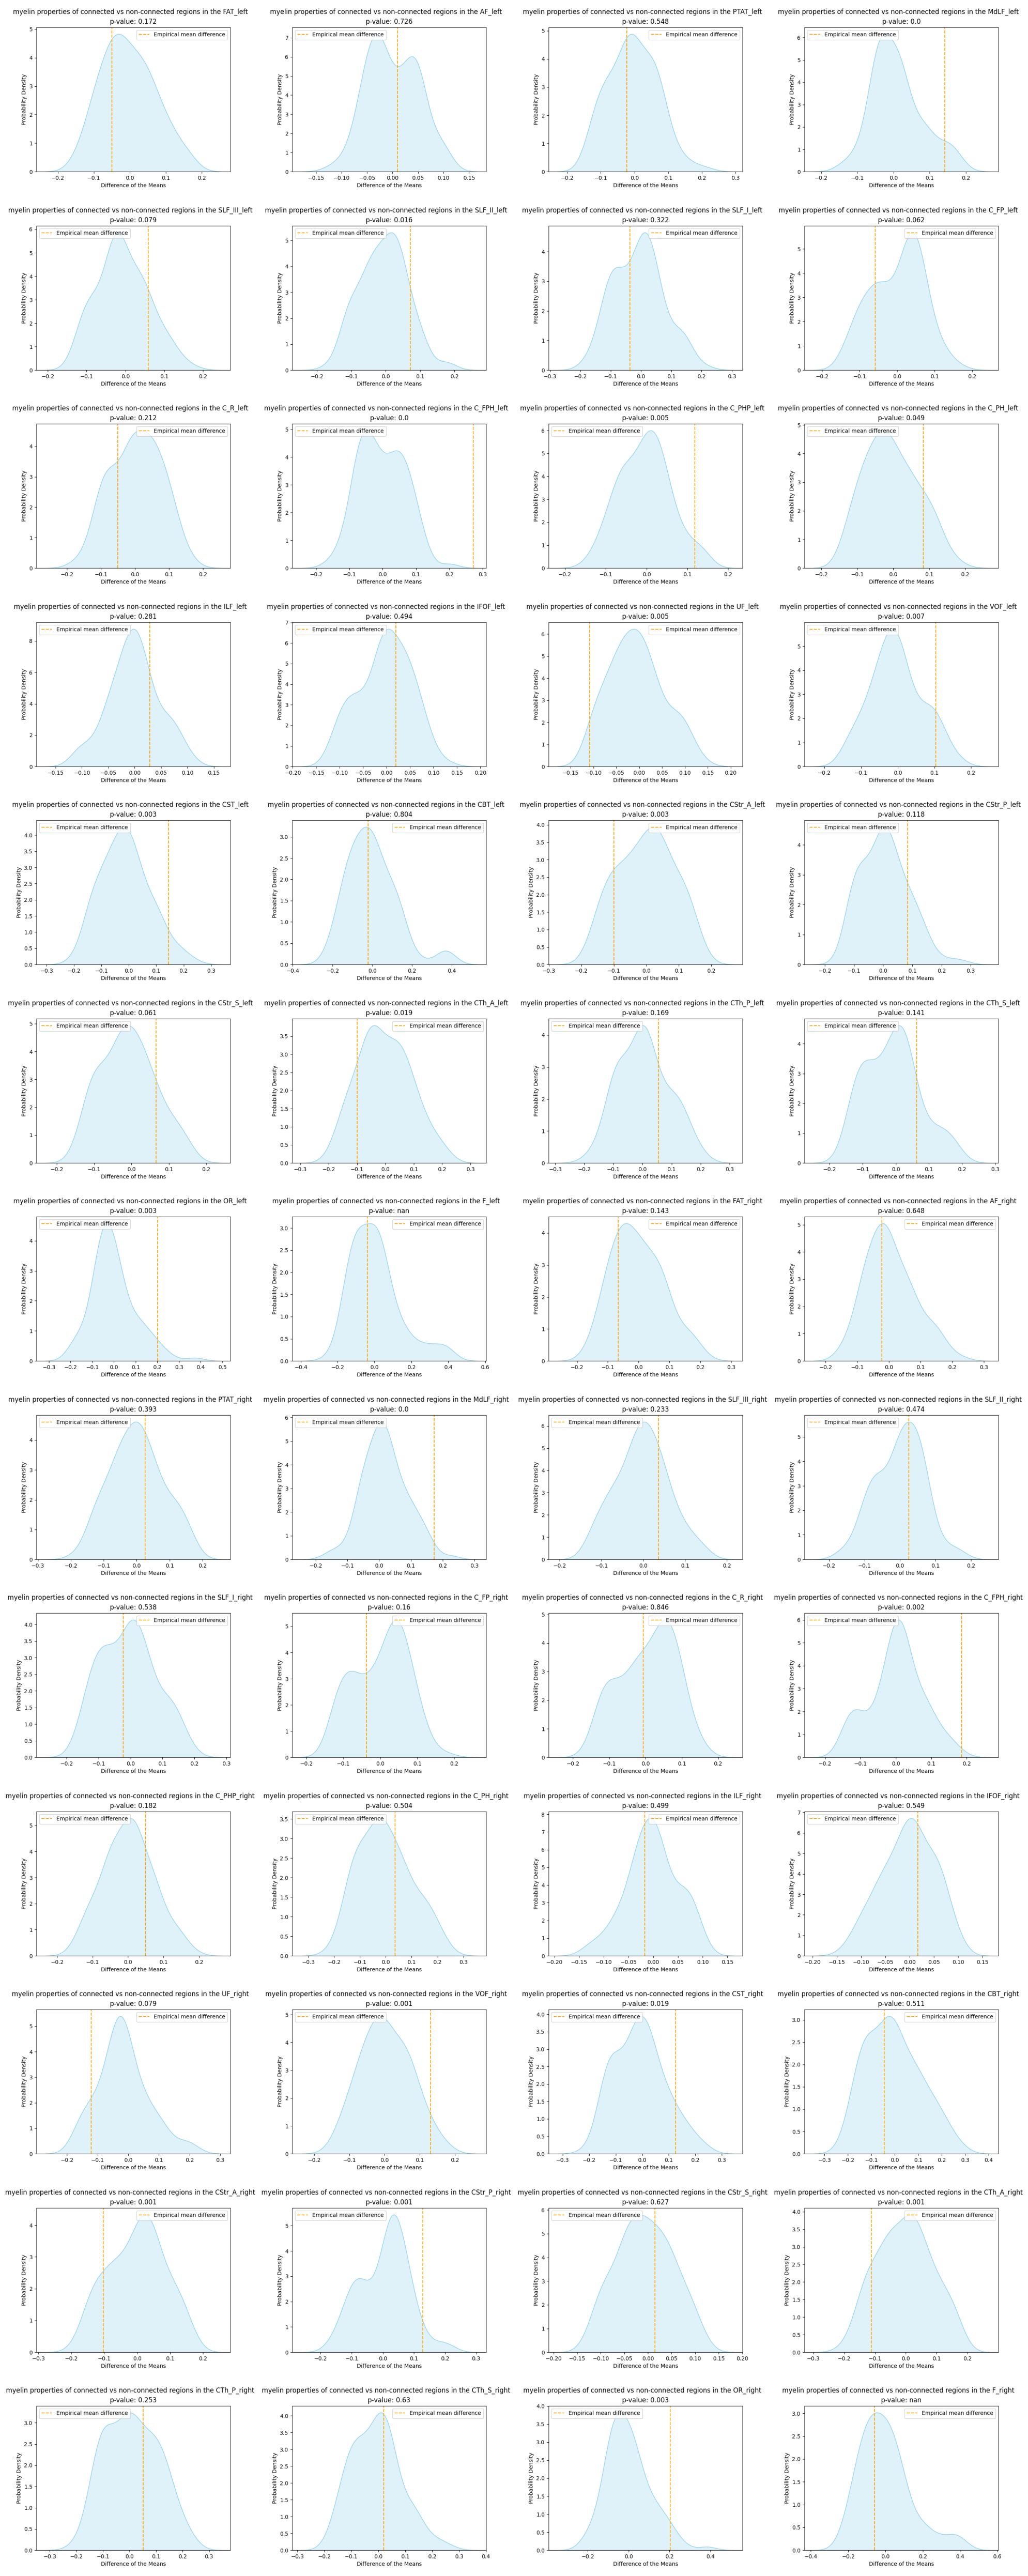

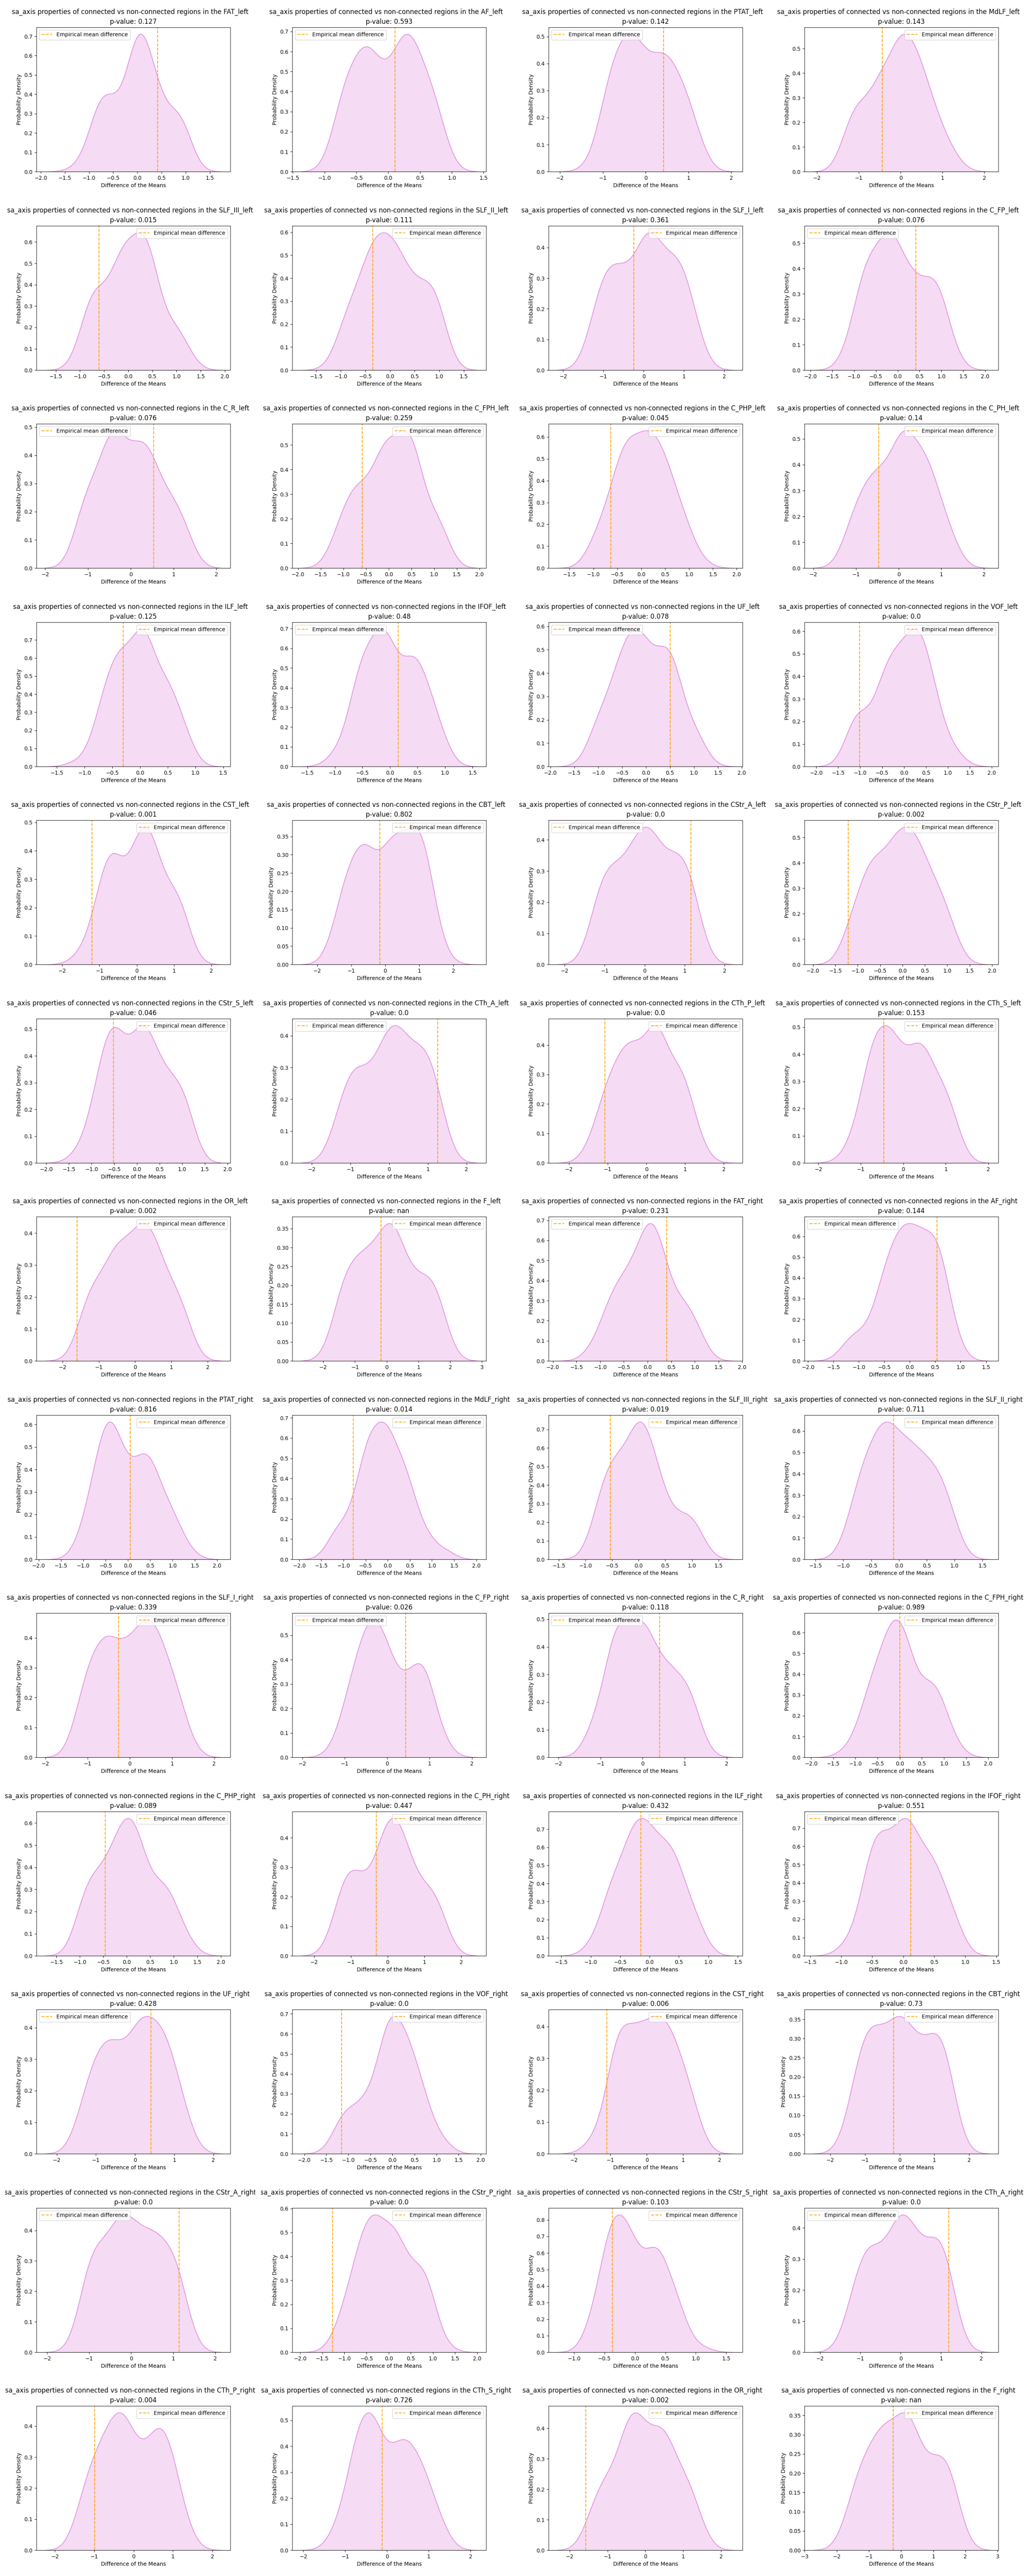

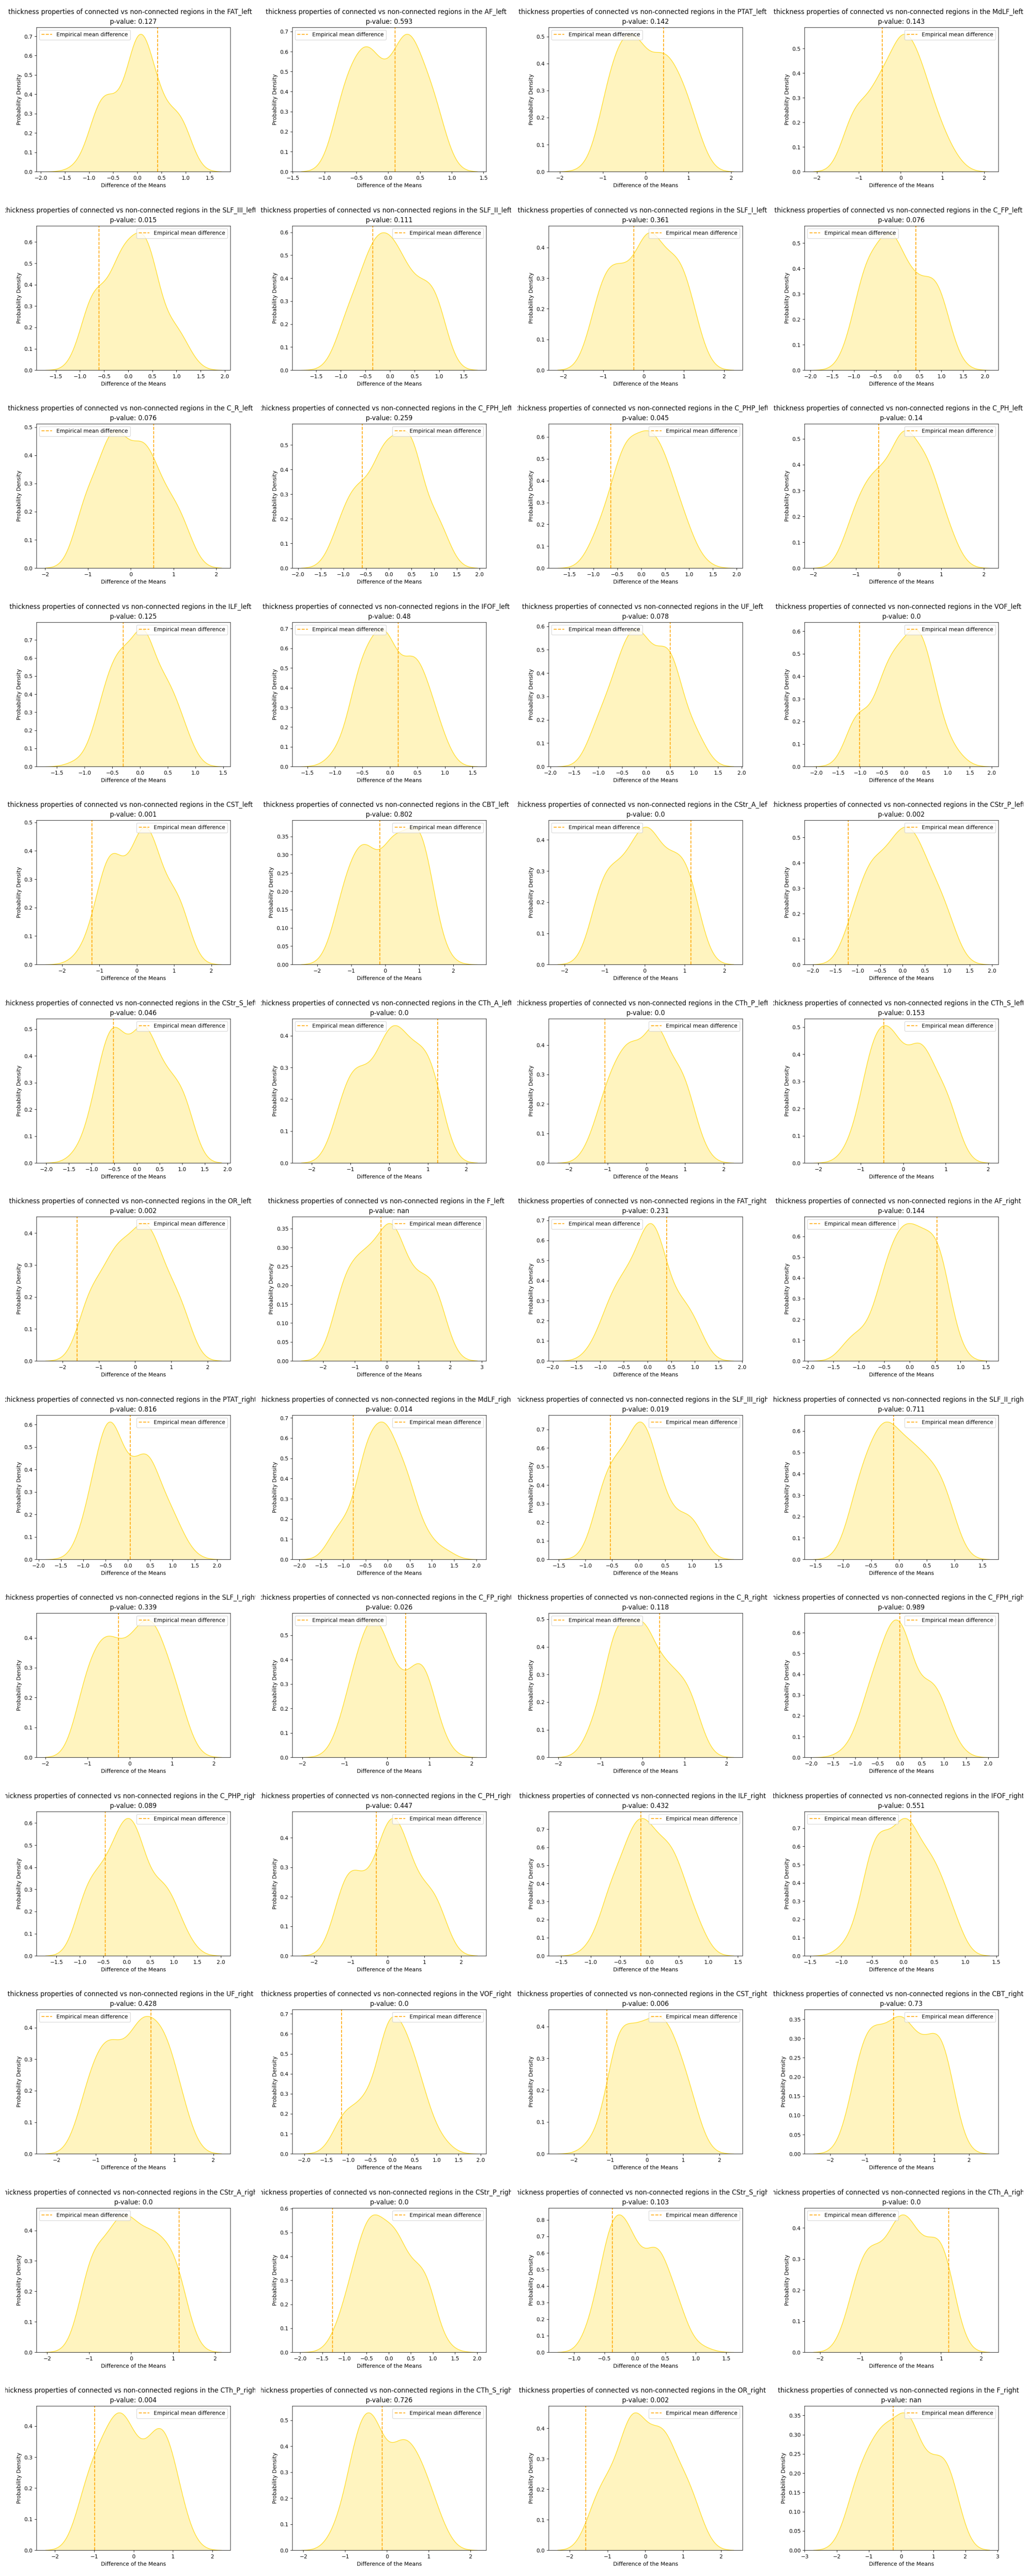

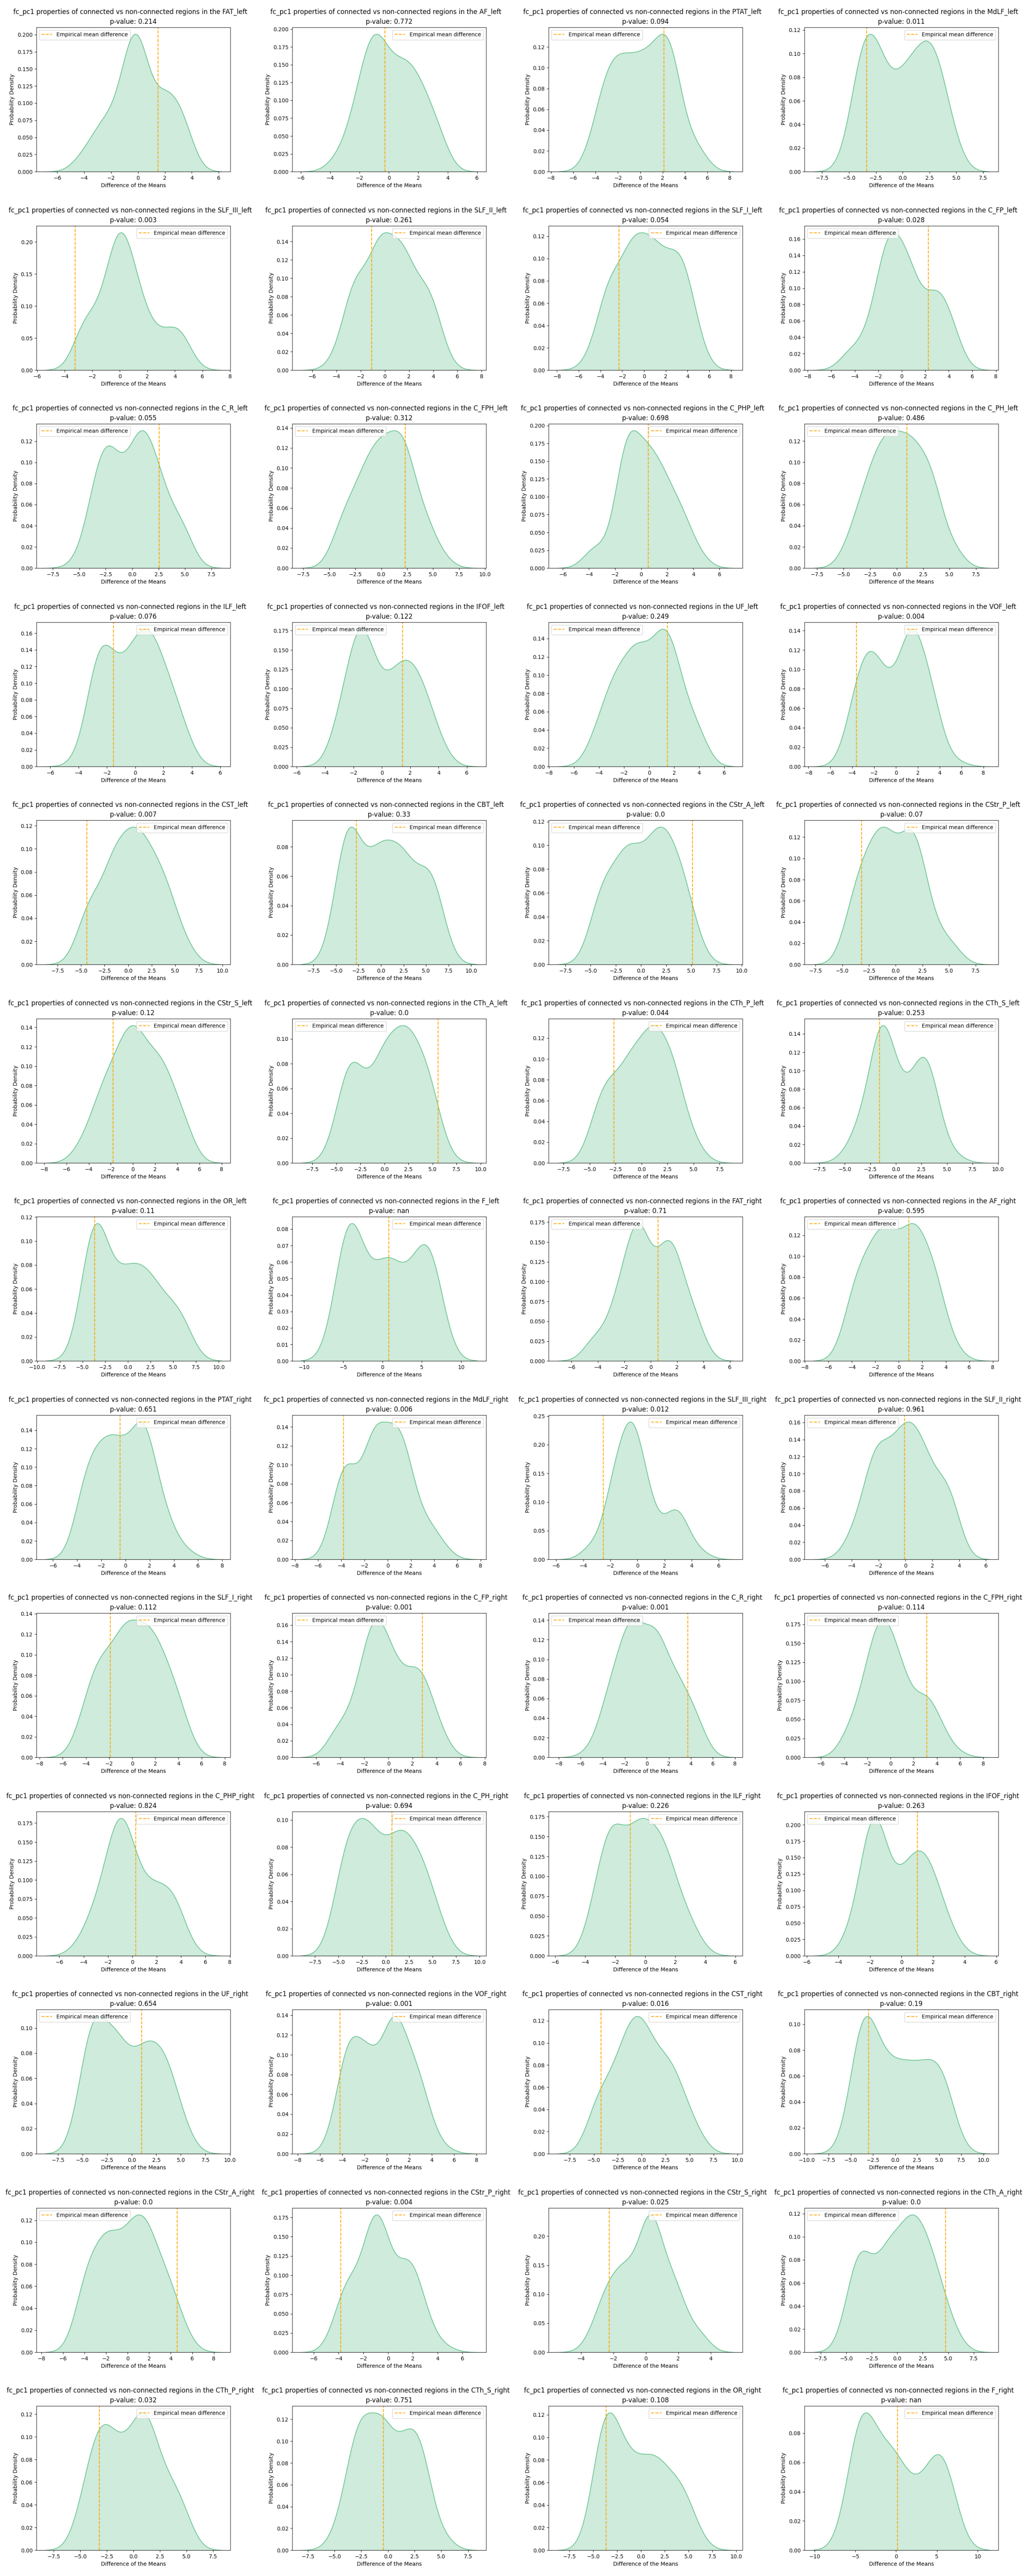

In [43]:
# all selected maps
maps_list = [myelin_glasser, sa_axis_glasser, thickness_glasser, fc_pc1_glasser]
map_names = ['myelin', 'sa_axis', 'thickness', 'fc_pc1', ]
density_colors = ['skyblue', 'orchid', 'gold', 'mediumseagreen']

# loop over all selected brain maps
for index, map_name in enumerate(map_names):

    # Create a figure and axes for the grid of subplots
    fig, axes = plt.subplots(13, 4, figsize = (20, 50)) #

    # Assign each plot to a specific subplot location
    for i, image_path in enumerate(all_image_paths[f'{map_name}']):
        row = i // 4
        col = i % 4
    #     print(row, col)
        # Load the saved image and display it in the subplot
        image = Image.open(image_path)
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

    # Adjust the layout and spacing of the subplots
    plt.tight_layout()

    # Save the figure containing the grid of subplots
    plt.savefig(f'./outputs/statistical_testing/plots_{map_name}_grid.png')

    # Show the plot grid (optional)
    plt.show()
